In [375]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

import pandas as pd
import tqdm
import h5py
from Bio import SeqIO

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2

In [376]:
def plot_save(history, filename):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['auc_roc'], label='Train AUC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC')
    plt.legend()
    plt.savefig(filename)
    plt.show()
    
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['auc_roc'], label='Train AUC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC')
    plt.legend()
    plt.show()

In [377]:
def prot_t5_model():
    # prot_t5
    M1_input = Input(shape=(1024,))
    M1_dense_1 = Dense(256)(M1_input)
    drop_out = Dropout(0.4)(M1_dense_1)
   
    M1_dense_2 = Dense(64, activation='relu')(drop_out)
    drop_out = Dropout(0.4)(M1_dense_2)
    #M1_dense_2 = Dense(128, activation='relu')(drop_out)
    #leaky_relu = LeakyReLU(alpha=0.3)(M1_dense_2)
    #drop_out = Dropout(0.7)(leaky_relu)
    M1_dense_3 = Dense(1, activation = 'sigmoid')(drop_out)
    model = Model(inputs=M1_input, outputs=M1_dense_3)
    return model

In [378]:
def read_h5(path):
    hf = h5py.File(path, 'r')
    mat = np.array(hf["embedding"])
    hf.close()
    return mat

In [379]:
test_positive_ST_embedding_pos = read_h5("../embeddings/test_positive_ST_embedding.h5")
test_negative_ST_embedding_pos = read_h5("../embeddings/test_negative_ST_embedding.h5")

In [380]:
test_positive_ST_labels = np.ones(test_positive_ST_embedding_pos.shape[0])
test_negative_ST_labels = np.zeros(test_negative_ST_embedding_pos.shape[0])

test_ST_labels = np.concatenate((test_positive_ST_labels, test_negative_ST_labels), axis = 0)
X_test_full_ST_embedding = np.vstack((test_positive_ST_embedding_pos, test_negative_ST_embedding_pos))

In [381]:
train_positive_ST_embedding_pos = read_h5("../embeddings/train_positive_ST_embedding.h5")
train_negative_ST_embedding_pos = read_h5("../embeddings/train_negative_ST_embedding.h5")

In [382]:
train_positive_ST_labels = np.ones(train_positive_ST_embedding_pos.shape[0])
train_negative_ST_labels = np.zeros(train_negative_ST_embedding_pos.shape[0])

train_ST_labels = np.concatenate((train_positive_ST_labels, train_negative_ST_labels), axis = 0)
X_train_full_ST_embedding = np.vstack((train_positive_ST_embedding_pos, train_negative_ST_embedding_pos))

In [450]:
X_train_full_ST_embedding.shape, train_ST_labels.shape,  X_test_full_ST_embedding.shape, test_ST_labels.shape

((1779, 1024), (1779,), (446, 1024), (446,))

In [384]:
def get_input_for_embedding(fasta_file):
    # This is returning just integers to feed to embedding layer
    
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    #print(char_to_int)
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        try:
            integer_encoded = [char_to_int[char] for char in data]
        except:
            continue
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    print(encodings.shape)
    return encodings


# convert sequences to integer encoding, for embedding
test_positive_ST_CNN = get_input_for_embedding('../dataset/test_Pos_ST.fasta')
test_negative_ST_CNN = get_input_for_embedding('../dataset/test_Neg_ST.fasta')

train_positive_ST_CNN = get_input_for_embedding('../dataset/train_Pos_ST.fasta')
train_negative_ST_CNN = get_input_for_embedding('../dataset/train_Neg_ST.fasta')

(222, 33)
(224, 33)
(890, 33)
(889, 33)


In [385]:
X_train_CNN = np.vstack((train_positive_ST_CNN, train_negative_ST_CNN))
X_test_CNN = np.vstack((test_positive_ST_CNN, test_negative_ST_CNN))
X_train_CNN.shape, X_test_CNN.shape, train_ST_labels.shape, test_ST_labels.shape

((1779, 33), (446, 33), (1779,), (446,))

In [386]:
X_train_CNN, train_ST_labels

(array([[ 2, 18, 16, ..., 15, 14, 15],
        [15,  7, 12, ...,  1, 16,  5],
        [ 5, 14,  5, ..., 15, 16, 18],
        ...,
        [ 0, 14, 10, ..., 19, 15,  7],
        [ 8,  0, 15, ...,  1, 10, 10],
        [ 3,  0, 10, ...,  3, 18, 11]]),
 array([1., 1., 1., ..., 0., 0., 0.]))

In [387]:
from tensorflow.keras import backend as K

def CNN_model():
    model = Sequential()
    model.add(Embedding(128, 21, input_length=33))
    model.add(Lambda(lambda x: tf.expand_dims(x, 3)))
    model.add(Conv2D(32, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model


#import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Layer, GlobalAveragePooling1D, Input, GlobalAveragePooling2D
#from tensorflow.keras.layers import Dense, Embedding
#from tensorflow.keras.models import Sequential


class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)] #Dense(4 * ff_dim, activation="relu")
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs, training):
        attn_output, attention_scores = self.att(inputs, inputs, inputs, return_attention_scores=True, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), attention_scores


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
# transformer based embedding model
def transformer_model():
    vocab_size = 21
    embed_dim = 32 #config["embedding_dim"]
    ff_dim = 32 #config["feed_forward_dim"]
    max_len = 33 #config["maximum_path_length"]
    dropout = 0.2 #config["dropout"]
    n_heads = 2

    inputs = Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, n_heads, ff_dim)
    x, weights = transformer_block(x)
    x = GlobalAveragePooling1D()(x) #GlobalAveragePooling1D
    x = Dropout(dropout)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=[outputs])

In [388]:
# Pretraining with Phosphorylation dataset

# S
pre_test_positive_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_S.fasta')
pre_test_negative_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_S.fasta')

pre_train_positive_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_S.fasta')
pre_train_negative_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_neg_S.fasta')

# T
pre_test_positive_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_T.fasta')
pre_test_negative_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_T.fasta')

pre_train_positive_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_T.fasta')
pre_train_negative_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_neg_T.fasta')


pre_test_pos_ST_CNN = np.vstack((pre_test_positive_S_CNN, pre_test_positive_T_CNN))
pre_test_neg_ST_CNN = np.vstack((pre_test_negative_S_CNN, pre_test_negative_T_CNN))

pre_train_pos_ST_CNN = np.vstack((pre_train_positive_S_CNN, pre_train_positive_T_CNN))
pre_train_neg_ST_CNN = np.vstack((pre_train_negative_S_CNN, pre_train_negative_T_CNN))

(3367, 33)
(3366, 33)
(13465, 33)
(13464, 33)
(856, 33)
(858, 33)
(3420, 33)
(3419, 33)


In [389]:
pre_test_pos_ST_CNN.shape, pre_test_neg_ST_CNN.shape, pre_train_pos_ST_CNN.shape, pre_train_neg_ST_CNN.shape

((4223, 33), (4224, 33), (16885, 33), (16883, 33))

In [390]:
pre_test_ST = np.vstack((pre_test_pos_ST_CNN, pre_test_neg_ST_CNN))

pre_test_positive_ST_labels = np.ones(pre_test_pos_ST_CNN.shape[0])
pre_test_negative_ST_labels = np.zeros(pre_test_neg_ST_CNN.shape[0])

pre_test_ST_labels = np.concatenate((pre_test_positive_ST_labels, pre_test_negative_ST_labels), axis = 0)
pre_test_ST.shape, pre_test_ST_labels.shape

((8447, 33), (8447,))

In [391]:
pre_train_ST = np.vstack((pre_train_pos_ST_CNN, pre_train_neg_ST_CNN))

pre_train_positive_ST_labels = np.ones(pre_train_pos_ST_CNN.shape[0])
pre_train_negative_ST_labels = np.zeros(pre_train_neg_ST_CNN.shape[0])

pre_train_ST_labels = np.concatenate((pre_train_positive_ST_labels, pre_train_negative_ST_labels), axis = 0)
pre_train_ST.shape, pre_train_ST_labels.shape

((33768, 33), (33768,))

In [392]:
pre_train_ST, pre_train_ST_labels

(array([[10,  1,  8, ..., 14, 10, 16],
        [ 0, 10,  5, ..., 10, 16,  7],
        [ 5,  6,  6, ...,  3, 14, 10],
        ...,
        [16, 12, 18, ...,  2, 15, 11],
        [ 8, 16,  7, ...,  7,  6,  1],
        [10,  7,  0, ...,  1,  0,  0]]),
 array([1., 1., 1., ..., 0., 0., 0.]))

In [393]:
X_train_CNN, train_ST_labels

(array([[ 2, 18, 16, ..., 15, 14, 15],
        [15,  7, 12, ...,  1, 16,  5],
        [ 5, 14,  5, ..., 15, 16, 18],
        ...,
        [ 0, 14, 10, ..., 19, 15,  7],
        [ 8,  0, 15, ...,  1, 10, 10],
        [ 3,  0, 10, ...,  3, 18, 11]]),
 array([1., 1., 1., ..., 0., 0., 0.]))

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_143 (Embedding)   (None, 33, 21)            2688      
                                                                 
 lambda_57 (Lambda)          (None, 33, 21, 1)         0         
                                                                 
 conv2d_57 (Conv2D)          (None, 17, 19, 32)        1664      
                                                                 
 dropout_320 (Dropout)       (None, 17, 19, 32)        0         
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 8, 9, 32)         0         
 g2D)                                                            
                                                                 
 flatten_57 (Flatten)        (None, 2304)              0         
                                                    

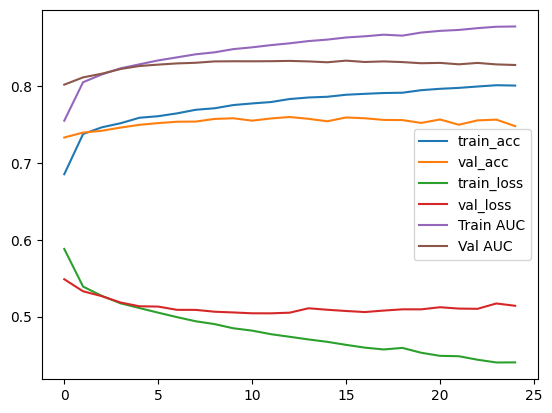


 Acc: 0.7476026991831419, MCC: 0.49676587560491003, SN:0.7871181624437603, SP:0.7080965909090909, 
 CM:[[2991 1233]
 [ 899 3324]]


In [473]:
# Pretraining CNN

n_epo_cnn = 25

metrics = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]

model_A = CNN_model()
model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

model_A.summary()

print("PRE Training CNN model...")

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

pre_history_A = model_A.fit(pre_train_ST, pre_train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[],
    validation_data=(pre_test_ST, pre_test_ST_labels))

# Save model
model_A.save_weights('../models/pre_model_A.h5')

y_pred = model_A.predict(pre_test_ST).reshape(pre_test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
a_pre_test_ST_labels = np.array(pre_test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(a_pre_test_ST_labels, y_pred)
mcc = matthews_corrcoef(a_pre_test_ST_labels, y_pred)
acc = accuracy_score(a_pre_test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(pre_history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Model: "model_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_61 (InputLayer)       [(None, 33)]              0         
                                                                 
 token_and_position_embeddin  (None, 33, 32)           1728      
 g_43 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_43 (Trans  ((None, 33, 32),         10656     
 formerBlock)                 (None, 2, 33, 33))                 
                                                                 
 global_average_pooling1d_43  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_324 (Dropout)       (None, 32)                0  

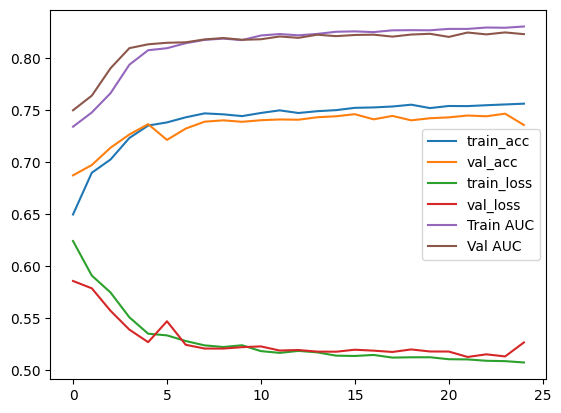


 Acc: 0.7358825618562803, MCC: 0.486259093905914, SN:0.8569737153682216, SP:0.6148200757575758, 
 CM:[[2597 1627]
 [ 604 3619]]


In [474]:
# Pretraining transformer

n_epo_transformer = 25
model_C = transformer_model()
model_C.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

model_C.summary()

print("PRE Training Transformer model...")

pre_history_C = model_C.fit(pre_train_ST, pre_train_ST_labels, batch_size=256, epochs=n_epo_transformer, verbose=1, callbacks=[],
    validation_data=(pre_test_ST, pre_test_ST_labels))

# Save model
model_C.save_weights('../models/pre_model_C.h5')

y_pred = model_C.predict(pre_test_ST).reshape(pre_test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
a_pre_test_ST_labels = np.array(pre_test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(a_pre_test_ST_labels, y_pred)
mcc = matthews_corrcoef(a_pre_test_ST_labels, y_pred)
acc = accuracy_score(a_pre_test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(pre_history_C)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [475]:
## Predict on real data using CNN

y_pred = model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

## Predict on real data using transformers

y_pred = model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


 Acc: 0.7937219730941704, MCC: 0.5946606430202428, SN:0.8693693693693694, SP:0.71875, 
 CM:[[161  63]
 [ 29 193]]

 Acc: 0.7869955156950673, MCC: 0.5900244943386442, SN:0.9009009009009009, SP:0.6741071428571429, 
 CM:[[151  73]
 [ 22 200]]


Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_146 (Embedding)   (None, 33, 21)            2688      
                                                                 
 lambda_58 (Lambda)          (None, 33, 21, 1)         0         
                                                                 
 conv2d_58 (Conv2D)          (None, 17, 19, 32)        1664      
                                                                 
 dropout_326 (Dropout)       (None, 17, 19, 32)        0         
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 8, 9, 32)         0         
 g2D)                                                            
                                                                 
 flatten_58 (Flatten)        (None, 2304)              0         
                                                    

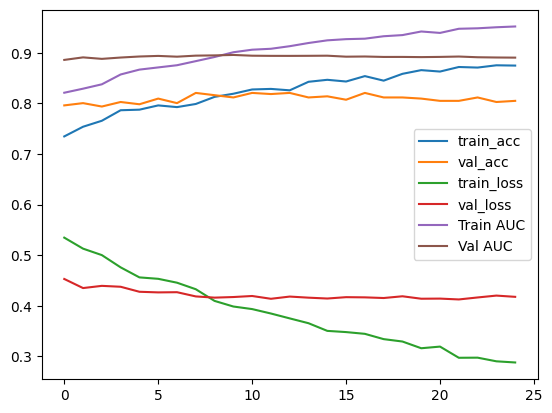


 Acc: 0.804932735426009, MCC: 0.6122312666959113, SN:0.8468468468468469, SP:0.7633928571428571, 
 CM:[[171  53]
 [ 34 188]]


In [476]:
# Training DE-Phosphorylation

iteration = 1
n_epo_cnn = 25

model_A = CNN_model()
model_A.load_weights('../models/pre_model_A.h5')
model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)
model_A.summary()

print("Training CNN model...")

#metrics = ['accuracy', tf.keras.metrics.AUC()]

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

history_A = model_A.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[], 
                        validation_data=(X_test_CNN, test_ST_labels))

# Save model
model_A.save_weights('../models/re_train_model_A.h5')

y_pred = model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Training Embedding model...
Epoch 1/10
7/7 [==============================] - 1s 36ms/step - loss: 0.6186 - accuracy: 0.6605 - auc_roc: 0.7652 - val_loss: 0.5045 - val_accuracy: 0.7578 - val_auc_roc: 0.8352
Epoch 2/10
7/7 [==============================] - 0s 11ms/step - loss: 0.5290 - accuracy: 0.7487 - auc_roc: 0.8151 - val_loss: 0.4858 - val_accuracy: 0.7803 - val_auc_roc: 0.8505
Epoch 3/10
7/7 [==============================] - 0s 9ms/step - loss: 0.4949 - accuracy: 0.7667 - auc_roc: 0.8424 - val_loss: 0.4756 - val_accuracy: 0.7848 - val_auc_roc: 0.8590
Epoch 4/10
7/7 [==============================] - 0s 11ms/step - loss: 0.4702 - accuracy: 0.7825 - auc_roc: 0.8610 - val_loss: 0.4616 - val_accuracy: 0.7937 - val_auc_roc: 0.8660
Epoch 5/10
7/7 [==============================] - 0s 12ms/step - loss: 0.4472 - accuracy: 0.7948 - auc_roc: 0.8733 - val_loss: 0.4553 - val_accuracy: 0.8049 - val_auc_roc: 0.8676
Epoch 6/10
7/7 [==============================] - 0s 12ms/step - loss: 0.4349 

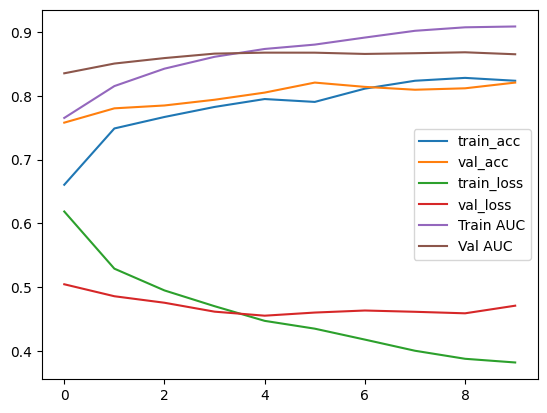


 Acc: 0.820627802690583, MCC: 0.6437003039635545, SN:0.7747747747747747, SP:0.8660714285714286, 
 CM:[[194  30]
 [ 50 172]]


In [477]:
########### Model B

print("Training Embedding model...")

n_epo_embed = 10
model_B = prot_t5_model()
model_B.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='auto')

history_B = model_B.fit(X_train_full_ST_embedding, train_ST_labels, batch_size=256, epochs=n_epo_embed, verbose=1, callbacks=[], 
                        validation_data=(X_test_full_ST_embedding, test_ST_labels))

model_B.save_weights('../models/re_train_model_B.h5')

y_pred = model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(history_B)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


Model: "model_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_63 (InputLayer)       [(None, 33)]              0         
                                                                 
 token_and_position_embeddin  (None, 33, 32)           1728      
 g_44 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_44 (Trans  ((None, 33, 32),         10656     
 formerBlock)                 (None, 2, 33, 33))                 
                                                                 
 global_average_pooling1d_44  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_332 (Dropout)       (None, 32)                0  

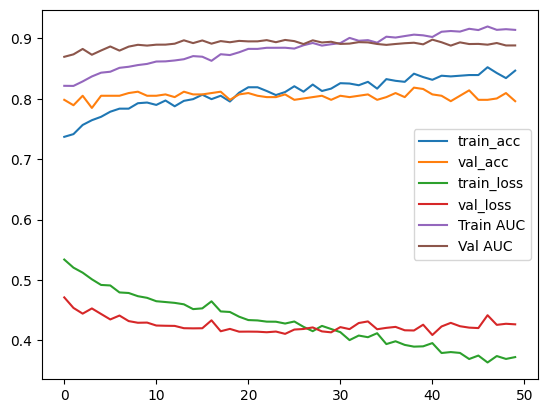


 Acc: 0.7959641255605381, MCC: 0.5930347593397998, SN:0.8243243243243243, SP:0.7678571428571429, 
 CM:[[172  52]
 [ 39 183]]


In [478]:
############# Training Transformer


model_C = transformer_model()
model_C.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)
model_C.load_weights('../models/pre_model_C.h5')
model_C.summary()

n_epo_transformer = 50

print("Training Transformer model...")

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

history_C = model_C.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_transformer, verbose=1,callbacks=[]
                        , validation_data=(X_test_CNN, test_ST_labels))

# Save model
model_C.save_weights('../models/re_train_model_C.h5')

y_pred = model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_C)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Loaded 3 models
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_114"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_164_input (InputLaye  [(None, 33)]        0           []                               
 r)                                                                                               
                                                                                                  
 embedding_164 (Embedding)      (None, 33, 21)       2688        ['embedding_164_input[0][0]']    
                                                                                                  
 lambda_64 (Lambda)             (None, 33, 21, 1)    0           ['embedding_164[0][0]']          
           

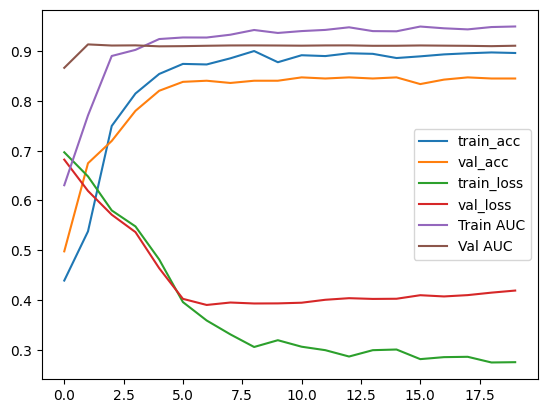


 Acc: 0.8452914798206278, MCC: 0.6918336091537449, SN:0.8738738738738738, SP:0.8169642857142857, 
 CM:[[183  41]
 [ 28 194]]


In [524]:
# load models from file
def load_A_models():
    model_A = CNN_model()
    model_A.load_weights('../models/re_train_model_A.h5')
    return model_A


def load_B_models():
    model = prot_t5_model()
    model.load_weights('../models/re_train_model_B.h5')
    return model

def load_C_models():
    model = transformer_model()
    model.load_weights('../models/re_train_model_C.h5')
    return model


# meta learner
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
#             layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
    ensemble_visible = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]
    #print(ensemble_visible)
    #print(ensemble_outputs)
    merge = concatenate(ensemble_outputs)
    hidden = Dense(32, activation='relu', name = 'ds_1')(merge)
    hidden = Dropout(0.4, name = 'dp_1')(hidden)
    hidden = Dense(16, activation='relu', name = 'ds_2')(hidden)
    hidden = Dropout(0.4, name = 'dp_2')(hidden)
    hidden = Dense(4, activation='relu', name = 'ds_3')(hidden)
#     hidden = Dropout(0.4, name = 'dp_1')(hidden)
#     hidden = Dense(4, activation='relu', name = 'ds_2')(hidden)

#     hidden = Dense(4, activation='relu', name = 'ds_3')(hidden)
#     hidden = Reshape((1,4))(hidden)X_train_embedding_full
#     hidden = Bidirectional(LSTM(32))(hidden)
#     hidden = Dropout(0.4, name = 'dp_2')(hidden)
    output = Dense(1, activation='sigmoid', name = 'ds_4')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    plot_model(model, show_shapes=True, to_file='ensemble_graph.png')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
    model.summary()
    return model


# fit a model
def fit_stacked_model(model, inputX, inputy):
    X = [inputX for _ in range(len(model.input))]
    inputy_enc = to_categorical(inputy)
    model.fit(X, inputy_enc, epochs=10, verbose=1)   


# prediction
def predict_stacked_model(model, inputX):
    X = [inputX for _ in range(len(model.input))]
    return model.predict(X, verbose=0)


# load all models
members = list()
model_A = load_A_models()
model_B = load_B_models()
model_C = load_C_models()

members.append(model_A)
members.append(model_B)
members.append(model_C)

n_epo_stacked = 20


print('Loaded %d models' % len(members))
stacked_model = define_stacked_model(members)

st_history = stacked_model.fit([X_train_CNN, X_train_full_ST_embedding, X_train_CNN], train_ST_labels, 
                               epochs=n_epo_stacked, verbose=1, 
                               validation_data=([X_test_CNN, X_test_full_ST_embedding, X_test_CNN], test_ST_labels))

# X_train_full_ST_embedding, X_test_full_ST_embedding

stacked_model.save_weights("../models/composite_model.h5")

# Predict
y_pred = stacked_model.predict([X_test_CNN, X_test_full_ST_embedding, X_test_CNN]).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(st_history)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [529]:
# load pretrained model
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import h5py


print("Number of layers: ", len(stacked_model.layers))

# create truncated model
truncated_ANN_model = Model(inputs=stacked_model.input,
                                 outputs=stacked_model.get_layer(index=25).output) #20

hidden_features = truncated_ANN_model.predict([X_test_CNN, X_test_full_ST_embedding, X_test_CNN])

print(hidden_features.shape)

df = pd.DataFrame()
df['Target'] = test_ST_labels

Number of layers:  31
(446, 32)


/home/anupkumar/anaconda3/envs/succsite/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


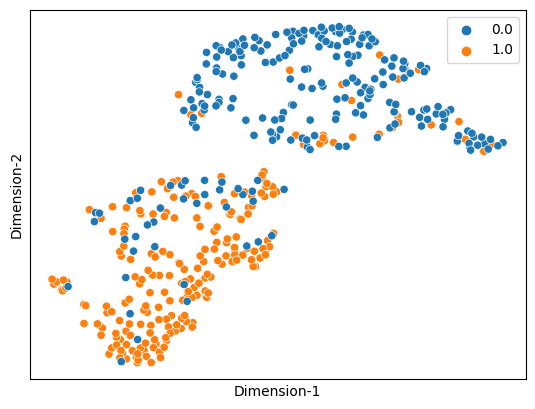

In [534]:
m = TSNE(learning_rate = 5, perplexity = 30) #learning_rate = 10, perplexity=30
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

sns.scatterplot(x="Dimension-1", y="Dimension-2", hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

plt.legend().set_visible(True)
filename = "TSNE_ANN_protT5.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

[Text(0.5, 1.0, 'UMAP projection')]

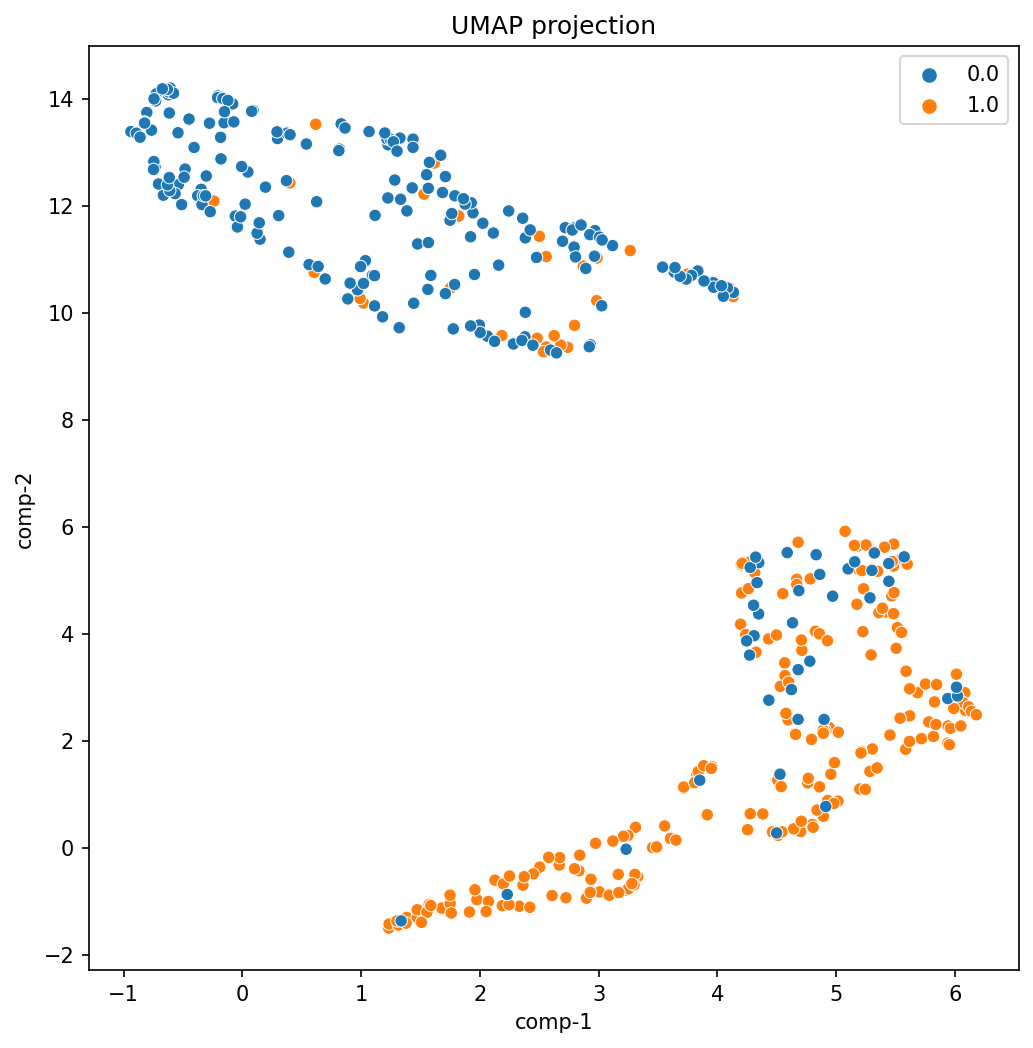

In [533]:
from umap import UMAP
from matplotlib.pyplot import figure

figsize = (8, 8)
figure(figsize=figsize, dpi=150)

n_colors = 10

n_neighbors = 30
min_dist= 0.09

n_components=2

metric='euclidean'

umap_2d = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, init='random', random_state=0)

#tsne_features = m.fit_transform(hidden_features)

#df['Dimension-1'] = tsne_features[:,0]
#df['Dimension-2'] = tsne_features[:,1]

proj_2d = umap_2d.fit_transform(hidden_features)

df_umap = pd.DataFrame()

df_umap["comp-1"] = proj_2d[:,0]
df_umap["comp-2"] = proj_2d[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=test_ST_labels, data=df_umap).set(title="UMAP projection") #palette=sns.color_palette("hls", n_colors)